In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data.csv', ',')

In [3]:
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


1. Переименовать поля

In [4]:
data.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [5]:
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [6]:
data['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [7]:
data = data.replace({'treatment':{'Buy One Get One':1, 'Discount':1, 'No Offer':0}})
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [8]:
data['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

2. Применим к столбцам recency и history - standardScaler, а к zip_code и channel - get_dummies

In [9]:
data['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [10]:
data['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
Add_df = pd.get_dummies(data.channel)
data = data.drop(['channel'], axis=1)
data = data.join(Add_df)

In [13]:
Add_df_1 = pd.get_dummies(data.zip_code)
data = data.drop(['zip_code'], axis=1)
data = data.join(Add_df_1)

In [14]:
scaler = StandardScaler()

data[['recency','history']] = scaler.fit_transform(data[['recency','history']])
data.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,Multichannel,Phone,Web,Rural,Surburban,Urban
0,1.207751,-0.389003,1,0,0,1,0,0,1,0,0,1,0
1,0.067359,0.339614,1,1,1,0,0,0,0,1,1,0,0
2,0.352457,-0.239836,0,1,1,1,0,0,0,1,0,1,0


In [15]:
#pip install scikit-uplift==0.2.0

2. Разбиение набора данных не тренировочную и тестовую выборки

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [17]:
data_train, data_test = train_test_split(data, test_size = 0.3, random_state=0)

In [18]:
data_train.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,Multichannel,Phone,Web,Rural,Surburban,Urban
26161,-1.358132,1.286691,0,1,1,1,0,0,1,0,0,1,0
10495,1.777948,-0.705372,1,0,0,1,0,0,0,1,0,0,1
50047,-0.787936,0.873311,0,1,0,1,0,0,0,1,0,1,0


In [19]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44800 entries, 26161 to 2732
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        44800 non-null  float64
 1   history        44800 non-null  float64
 2   used_discount  44800 non-null  int64  
 3   used_bogo      44800 non-null  int64  
 4   is_referral    44800 non-null  int64  
 5   treatment      44800 non-null  int64  
 6   target         44800 non-null  int64  
 7   Multichannel   44800 non-null  uint8  
 8   Phone          44800 non-null  uint8  
 9   Web            44800 non-null  uint8  
 10  Rural          44800 non-null  uint8  
 11  Surburban      44800 non-null  uint8  
 12  Urban          44800 non-null  uint8  
dtypes: float64(2), int64(5), uint8(6)
memory usage: 3.0 MB


4. Одна модель с признаком коммуникации (S learner)

In [20]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
%matplotlib inline

In [21]:
X_train = data_train.drop('target', axis = 1)
y_train = data_train['target']
treat_train = data_train['treatment']

X_test = data_test.drop('target', axis = 1)
y_test = data_test['target']
treat_test = data_test['treatment']

In [22]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

uplift@10%: 0.0617


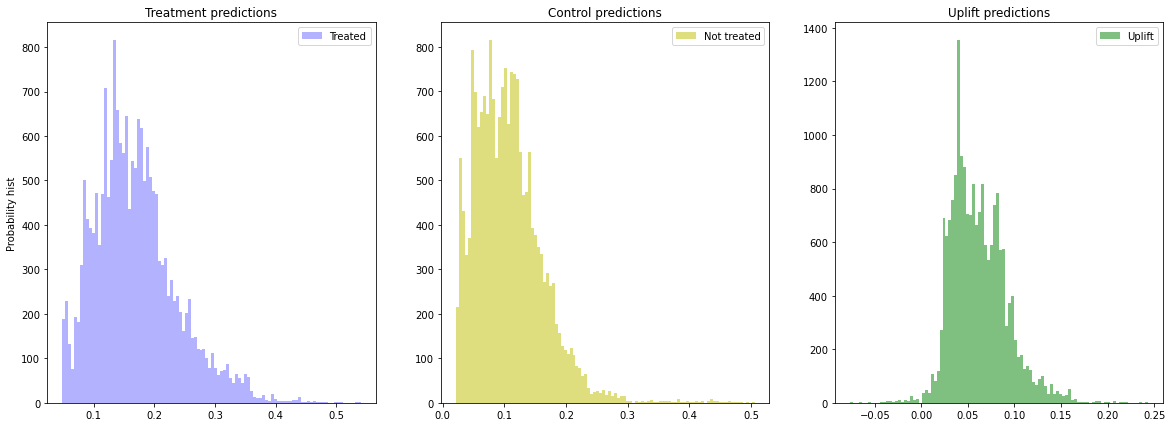

In [23]:
solo_model = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
solo_model = solo_model.fit(X_train, y_train, treat_train)

uplift_solo_model = solo_model.predict(X_test)

solo_model_score = uplift_at_k(y_true=y_test, uplift=uplift_solo_model, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {solo_model_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(solo_model_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
solo_model_trmnt_preds = solo_model.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
solo_model_ctrl_preds = solo_model.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=solo_model_trmnt_preds, ctrl_preds=solo_model_ctrl_preds);

uplift@20%: 0.0577


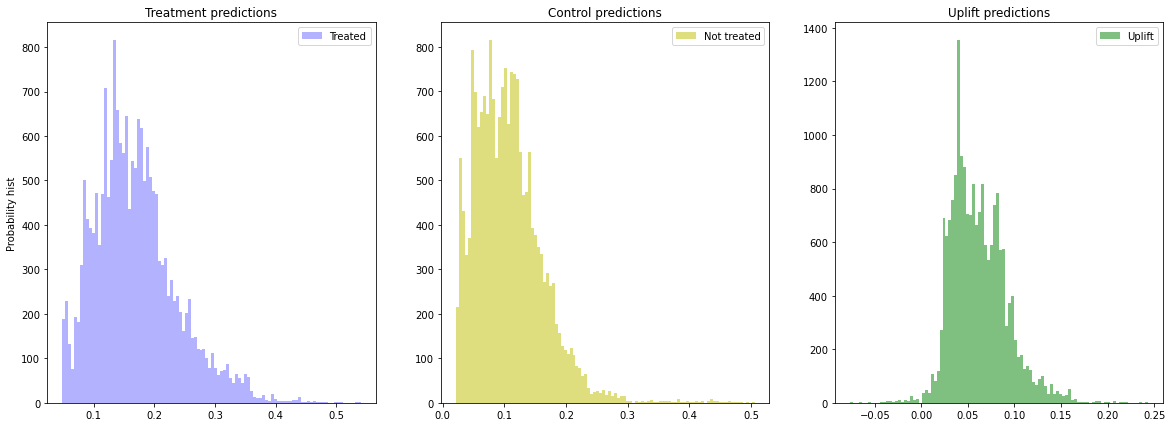

In [24]:
solo_model_score = uplift_at_k(y_true=y_test, uplift=uplift_solo_model, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@20%: {solo_model_score:.4f}')

#models_results['approach'] = 'SoloModel'
models_results['uplift@20%'].append(solo_model_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
solo_model_trmnt_preds = solo_model.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
solo_model_ctrl_preds = solo_model.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=solo_model_trmnt_preds, ctrl_preds=solo_model_ctrl_preds);

5.  Модель с трансформацией таргета

In [25]:
from sklift.models import ClassTransformation


ct_model = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct_model = ct_model.fit(X_train, y_train, treat_train)

uplift_ct_model = ct_model.predict(X_test)

ct_model_score = uplift_at_k(y_true=y_test, uplift=uplift_ct_model, treatment=treat_test, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_model_score)

<ipython-input-25-3c42fbd5a99e>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct_model = ct_model.fit(X_train, y_train, treat_train)


In [26]:
ct_model_score = uplift_at_k(y_true=y_test, uplift=uplift_ct_model, treatment=treat_test, strategy='by_group', k=0.2)

models_results['uplift@20%'].append(ct_model_score)

6. Две независимые модели

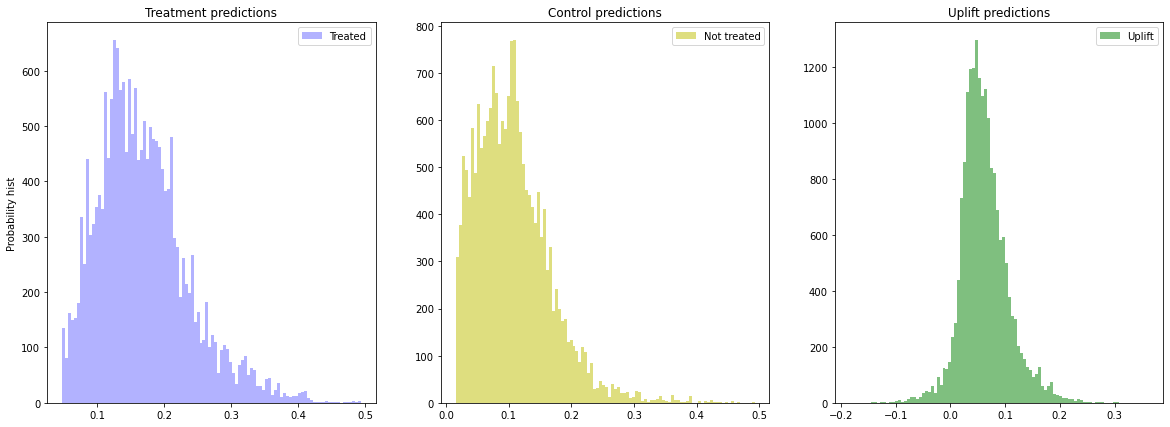

In [27]:
from sklift.models import TwoModels


two_model = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
two_model = two_model.fit(X_train, y_train, treat_train)    

uplift_two_model = two_model.predict(X_test)

two_model_score = uplift_at_k(y_true=y_test, uplift=uplift_two_model, treatment=treat_test, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(two_model_score)

plot_uplift_preds(trmnt_preds=two_model.trmnt_preds_, ctrl_preds=two_model.ctrl_preds_);

In [28]:
two_model_score = uplift_at_k(y_true=y_test, uplift=uplift_two_model, treatment=treat_test, strategy='by_group', k=0.2)

models_results['uplift@20%'].append(two_model_score)

7. Сравнение результатов

In [35]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.061692,0.057653
1,ClassTransformation,0.230373,0.190662
2,TwoModels,0.087785,0.063176


8. Модель UpliftTreeClassifier

In [30]:
#!git clone https://github.com/ub8er/causalml.git
#%cd causalml
#!pip install -r requirements.txt
#!python setup.py build_ext --inplace
#!python setup.py install

Wall time: 49.1 s


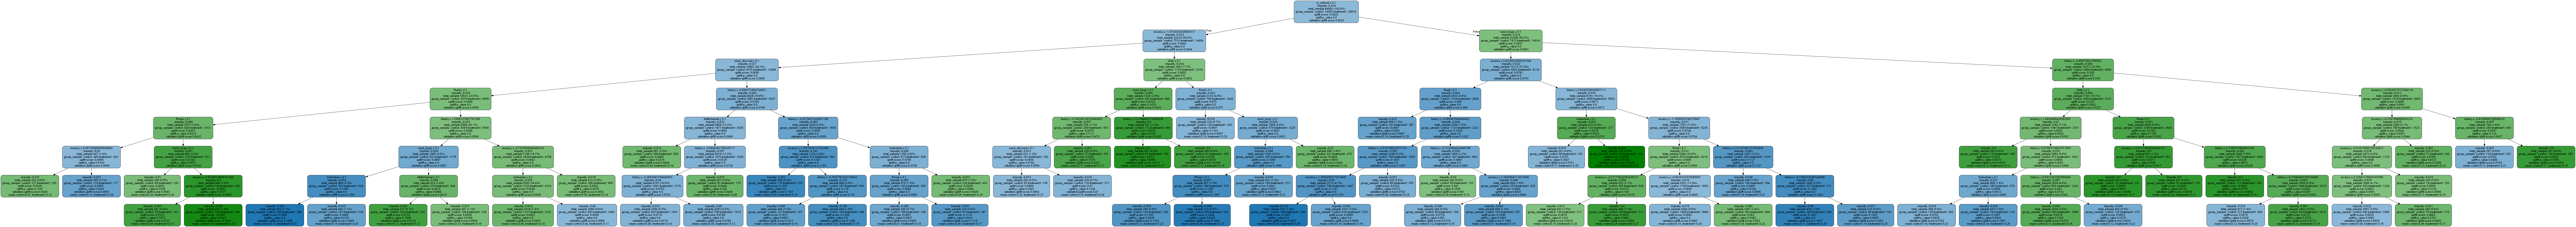

In [31]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

features = [col for col in X_train]

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())
